<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC3
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Recurrent Neural Networks

En esta práctica implementaremos redes neuronales recurrentes para generar música.

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-success">
<strong>Javier Gómez de Diego</strong>
</div>

# 0. Contexto y referencias

Esta PEC está basada en el siguiente [artículo de investigación](https://arxiv.org/pdf/1711.07682.pdf), aunque por motivos de extensión no podremos pasar por todos los puntos del artículo.

La primera etapa de esta PEC será leer y entender la idea general de este trabajo. El artículo os da acceso al código original con el que se ha llevado a cabo el trabajo y en el que además esta basado gran parte del código que aquí os adjuntamos, aunque por la complejidad y extensión del código no os recomendamos que sumergáis demasiado en él.

La PEC consta de una etapa de ***interpretación de los datos*** (un paso vital en todo proyecto real), donde se pedirá reproducir una gráfica del artículo. Luego ***entrenaremos*** una red LSTM para generar acordes a partir de archivos MIDI. Finalmente, usaremos la capa de ***embedding*** de la red entrenada para hacer una proyección de los acordes en 2D y visualizar el concepto de [word2vec](https://en.wikipedia.org/wiki/Word2vec).

Además de este fichero os hemos adjuntado un archivo comprimido con una estructura de datos similar a la usada en el artículo y que os recomendamos (por vuestro bien) que no modifiquéis :). Allí encontraréis una carpeta llamada *data* donde se encuentra la base de datos que usaremos y otros ficheros que os facilitamos con datos de redes ya entrenadas (en la carpeta *models*)

# 1. Procesado de datos [2.5 pts]

## 1.1 Importación de módulos y paquetes necesarios

In [1]:
# añade el path a tu directorio
%cd PEC3_PAC3

C:\Users\javi2\OneDrive - Universitat Oberta de Catalunya\UOC\2º Semestre\Deep Learning\Módulo 3\PEC 3\PEC3_PAC3


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
import pretty_midi as pm
import mido
from collections import Counter
import collections
import pandas as pd

Importamos módulos propios (archivos .py) que podréis encontrar en la estructura de carpetas que os hemos facilitado

In [3]:
from settings import *
import midi_functions as mf 
import data_processing_functions as dpf

## 1.2 Ficheros MIDI [1 pt]

En esta sección vamos a entender un poco mejor la información que contiene un fichero MIDI y reproduciremos un archivo de nuestra base de datos. Para esta sección os recomendamos que le echéis un vistazo a la sección "*Extract notes*" del siguiente [tutorial de tensorflow](https://www.tensorflow.org/tutorials/audio/music_generation).

1.2.1 Escoger un fichero MIDI de la base de datos y crear las funciones necesarias para extraer las notas, el tiempo en que se toca cada nota, su duración y el momento en que se tocan. Este proceso se debe aplicar solo a un instrumento: **"Acoustic Grand Piano"**. 

*Nota: Si el fichero escogido no tiene piano elegir otro fichero*

In [4]:
def get_notes(mf: str) -> pd.DataFrame:
    p = pm.PrettyMIDI(mf)
    instrument = p.instruments[0]
    notes = collections.defaultdict(list)
    
    # Sort notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        gnn = np.vectorize(pm.note_number_to_name)
        notes['Nombre'].append(gnn(note.pitch))
        notes['Nota'].append(note.pitch)
        notes['Comienzo'].append(start)
        notes['Fin'].append(end)
        notes['Duración'].append(end - start)
        notes['Step'].append(start - prev_start)
        prev_start = start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

n = [str(os.getcwd() + '/data/original/' + names) for names in os.listdir(str(os.getcwd() + '/data/original'))]
get_notes(n[6])

,Nombre,Nota,Comienzo,Fin,Duración,Step
0,C#4,61,163.15,163.941667,0.791667,0.0
1,A3,57,163.15,163.941667,0.791667,0.0
2,E4,64,163.35,163.541667,0.191667,0.2
3,A4,69,163.55,163.741667,0.191667,0.2
4,E5,76,163.75,164.141667,0.391667,0.2
...,...,...,...,...,...,...
70,B3,59,185.35,185.541667,0.191667,0.2
71,E4,64,185.55,185.741667,0.191667,0.2
72,A3,57,185.55,187.541667,1.991667,0.0
73,D4,62,185.75,186.141667,0.391667,0.2


1.2.2 Modificar la funcion *plot_piano_roll* del tutorial para poder graficar el pianoroll de la canción MIDI escogida. En este caso deberemos poder indicar un tiempo máximo de la canción que queremos añadir en el pianoroll. Además, si pasamos un *max_time=-1*, se deberán graficar todas las notas de la canción

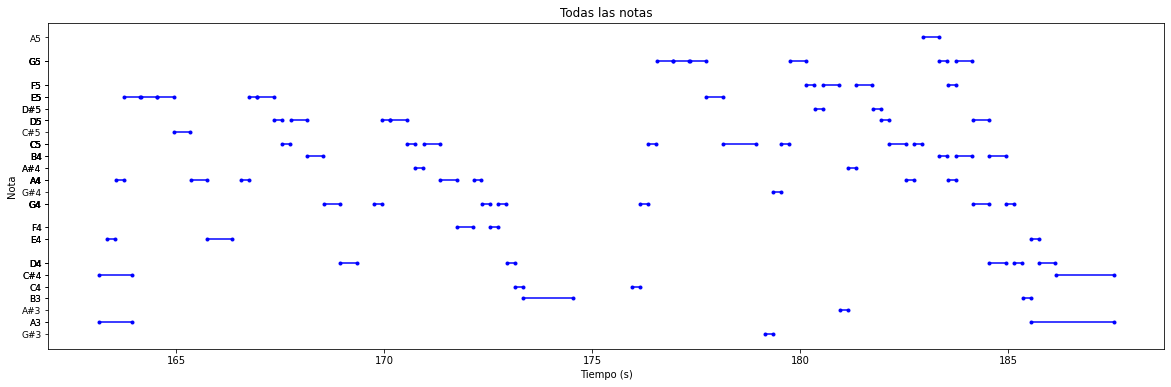

In [5]:
def plot_piano_roll(notes: pd.DataFrame, max_time: float):
    if (max_time < notes['Comienzo'].loc[0] and max_time!=-1):
        print('Nada que mostrar: max_time debe ser == -1 (mostrar todas las notas) o >', round(notes['Comienzo'].loc[0], 2), '(comienzo de la primera nota)')
    else:
        if max_time == -1:
            title = 'Todas las notas'
            max_time = max(notes['Fin'])
        else:
            title = str('Hasta ' + str(max_time) + ' segundos')
            count = len(notes['Nota'])
        
        t=[]
        c=[]
        f=[]
        for i in range(len(notes)):
            if notes['Comienzo'].loc[i] < max_time:
                t.append(notes['Nota'].loc[i])
                c.append(notes['Comienzo'].loc[i])
                if notes['Fin'].loc[i] > max_time:
                    f.append(max_time)
                else: f.append(notes['Fin'].loc[i])
            else: break
        
        plt.figure(figsize=(20, 6))
        plot_pitch = np.stack([t, t], axis=0)
        plot_start_stop = np.stack([c, f], axis=0)
        plt.plot(
            plot_start_stop, plot_pitch, color="b", marker=".")
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Nota')
        plt.yticks(notes['Nota'], labels = notes['Nombre'], fontsize=9)
        _ = plt.title(title)

plot_piano_roll(get_notes(n[6]), -1)

## 1.3 Procesado de datos [1.5 pts]

Ahora volvemos al artículo y aplicaremos el procesado de datos. Buscar dentro del fichero *data_processing_functions.py* la función que se encarga de llevar a cabo todo el procesado de datos y llamarla desde aquí

In [6]:
dpf.do_all_steps()

changing Tempo
histogramming
data/tempo/


D:\Programas\Python\anaconda3\lib\site-packages\pretty_midi\pretty_midi.py:96: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


make song histo
shifting midi files
making note indexes
histogramming
data/shifted/tempo/
extracting chords
getting dictionary
converting chords to index sequences
done


1.3.1 ¿Qué hace la función *change_tempo_folder*?¿Qué bpm fija para las canciones?

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>Reescribe el archivo MIDI indicado en una nueva carpeta indicada, manteniendo los mismos <b>bpm</b> -<i>ticks_per_minute</i>- (<i>new_mid.ticks_per_beat</i> = <i>mid.ticks_per_beat</i>).

</div>

1.3.2 Una vez tenemos ejecutado el procesado de datos se habrán creado muchas carpetas y muchos ficheros nuevos en la actual carpeta ***data***. Ahora usaremos algunos de estos ficheros para construir la figura 2 del artículo usando los datos procesados. Crearemos dos funciones:
*   my_save_histo_oct_from_midi_folder
*   my_midi_to_histo_oct

basadas en las funciones ***save_histo_oct_from_midi_folder*** y ***midi_to_histo_oct*** que encontraréis en los ficheros ***midi_functions.py*** y ***data_processing_functions.py***. Ahora las modificaremos para que nos devuelvan datos para dos tipos de histogramas: uno igual a la figura 2 del artículo (apariciones VS pitch) y otro, usando el *histo_oct*, que serán datos para graficar *apariciones VS notas en cualquier octava*, es decir, el número de veces que aparece una nota (sin importar a que octava pertenezca) a lo largo de una canción.


*Indicación: Es importante entender la estructura de las variables:*
*   pianoroll
*   histo_bar
*   histo_oct

*dentro de la funcion* ***midi_to_histo_oct***

In [7]:
#usa este vector como labels del segundo gráfico 
notas_en_una_octava = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

In [8]:
def my_save_histo_oct_from_midi_folder(tempo_folder, histo_folder):
    nfiles=0
    ahisto_bar = [0] * 128
    ahisto_oct = [0] * 12
    for path, subdirs, files in os.walk(tempo_folder):
        for name in files:
            _path = path.replace('\\', '/') + '/'
            _name = name.replace('\\', '/')
            target_path = histo_folder+_path[len(tempo_folder):]
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            try:
                nfiles+=1
                if nfiles%100==0:
                      print("File #",nfiles,"Current file = ",_path,"/",_name) 
                ahb, aho = my_midi_to_histo_oct(samples_per_bar, octave, fs, _name, _path, target_path)
                ahbt = []
                ahot = []
                for i in range(len(ahb)):
                    ahbt.append(sum(ahb[i]))
                    if i < len(aho):
                        ahot.append(sum(aho[i]))
                ahisto_bar = np.add(ahisto_bar, ahbt)
                ahisto_oct = np.add(ahisto_oct, ahot)
                #ahisto_bar.append(ahbt)
                #ahisto_oct.append(ahot)
            except (ValueError, EOFError, IndexError, OSError, KeyError, ZeroDivisionError) as e:
                exception_str = 'Unexpected error in ' + name  + ':\n', e, sys.exc_info()[0]
                print(exception_str)
    return ahisto_bar, ahisto_oct

def my_midi_to_histo_oct(samples_per_bar,octave, fs, name, path, histo_path):
#   print(path + name)
    notes_in_songs = [0] * 128
    octave_notes_in_songs = [0] * 12
    pianoroll = mf.get_pianoroll(name, path, fs)
    histo_bar = mf.pianoroll_to_histo_bar(pianoroll, samples_per_bar)
    histo_oct = mf.histo_bar_to_histo_oct(histo_bar, octave)
    pickle.dump(histo_oct,open(histo_path + name + '.pickle' , 'wb'))
    return histo_bar, histo_oct

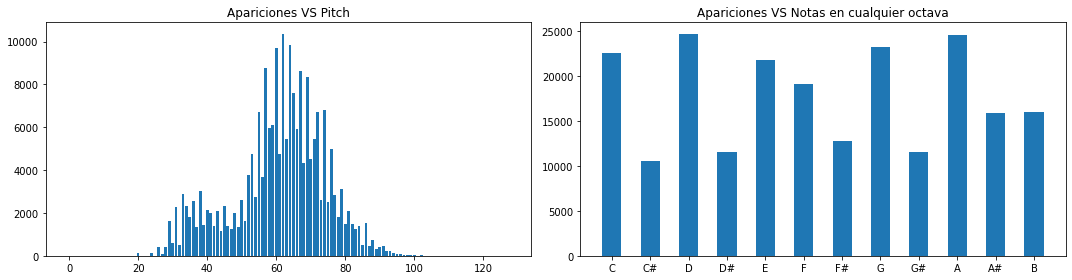

In [9]:
hb, ho = my_save_histo_oct_from_midi_folder(str(os.getcwd() + '/data/tempo'), str(os.getcwd() + '/data/histo'))

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].bar([i for i in range(len(hb))], hb)
ax[0].set_title('Apariciones VS Pitch')
ax[1].bar(notas_en_una_octava, ho, width = .5)
ax[1].set_title('Apariciones VS Notas en cualquier octava')

plt.tight_layout()

1.3.3 Buscar en internet sobre las escalas musicales e indicar que escala es la que más aparece en todas las canciones analizadas. ¿Cuáles dirías que son las notas más importantes de la escala?

In [10]:
scale = -np.sort(-hb)
max_notes = []
for i in scale[0:10]:
    max_notes.append(np.where(hb == i)[0][0])
    
gnn = np.vectorize(pm.note_number_to_name)
print('Las notas más repetidas son:',gnn(max_notes))

Las notas más repetidas son: ['D4' 'E4' 'C4' 'A3' 'G4' 'A4' 'F4' 'D5' 'G3' 'C5']


<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>En base a las notas más repetidas, la escala que más encaja con éstas es la escala de <b><i>C mayor</i></b> (formada por las notas <b>C, D, E, F, G, A, B, C</b>; todas ellas entre las notas más repetidas), específicamente en la 4 octava. Además, se puede comprobar por la falta de sostenidos y bemoles (naturales de otras escalas) entre las notas más utilizadas.

</div>

# 2. LSTM para acordes [5 pts]

El siguiente paso en el artículo es el entrenamiento de una red LSTM para la generación de acordes. Esta parte la haremos con un data set más pequeño y lo compararemos con resultados de entrenamientos previos que os faciliaremos. Primero cargamos la librerias que necesitaremos

In [11]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras.utils
from keras.utils import np_utils
from random import shuffle
import progressbar
import time

## 2.1 Carga de datos [0.5 pts]

2.1.1 En la carpeta ***data*** encontraréis un fichero llamado ***dataset.pkl*** que contiene 11338 canciones de train y 3780 de test. Usando *pickle* cargar los datos y luego separar 2000 para *train* y 500 canciones para *test* en las variables: 
*   train_set
*   test_set

Crea además *train_set_size* y *test_set_size*

In [12]:
x = open('data/dataset.pkl', 'rb')

x1 = pickle.load(x)
train_set = x1[0][:2000]
test_set = x1[1][:500]
train_set_size = len(train_set)
test_set_size = len(test_set)
print('train_set_size:', train_set_size,
      '\ntest_set_size:', test_set_size)

x.close()

train_set_size: 2000 
test_set_size: 500


## 2.2 Modelo con una capa de ***Embedding*** [0.5 pts]

2.2.1 Ahora definiremos los parámetros de nuestra red LSTM usando los parámetros que dan en el artículo. El único cambio será en el tamaño de la red LSTM, en la que usaremos la mitad de la LSTM del artículo y número de epochs que usaremos 10 en nuestro caso

In [13]:
batch_size = 1
step_size = 1
epochs = 10

#completar
lstm_size = 128
learning_rate = 0.00001
optimizer = 'Adam'

El siguiente código es para mantener la estructura de carpetas que usan en el artículo ya que hay mucho código que depende de esta estructura:

In [14]:
##--------NO TOCAR-------------------------------------------------------
base_path = 'models/chords/'
model_filetype = '.pickle'

shuffle_train_set = True
bidirectional = False

#Create model dir
fd = {'shifted': shifted, 'lr': learning_rate, 'emdim': chord_embedding_dim, 'opt': optimizer,
'bi': bidirectional, 'lstms': lstm_size, 'trainsize': train_set_size, 'testsize': test_set_size, 'samples_per_bar': samples_per_bar}
t = str(np.random.randint(1000,9999))
model_name = t # Se acorta el nombre para evitar problemas de longitud
model_path = base_path + model_name + '/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
##--------NO TOCAR-------------------------------------------------------


2.2.2 Finalmente definimos y compilamos la red con una capa de Embedding antes de la LSTM. Para este paso, acceder al código original del artículo y buscar en que fichero se entrena la LSTM copiar la estructura eliminando código que no es de nuestro interés

In [15]:
model = Sequential()
model.add(Embedding(num_chords, chord_embedding_dim,
                    input_length=step_size,
                    name="embedding",
                    batch_input_shape=(batch_size,step_size)))

model.add(LSTM(lstm_size, stateful=True))
model.add(Dense(num_chords))
model.add(Activation('softmax'))
optimizer = Adam(learning_rate=learning_rate)
loss = 'categorical_crossentropy'

model.compile(optimizer, loss)

## 2.3 Entrenamiento [2 pts]

2.3.1 Siguiendo el código orginal del artículo donde se define la arquitectura de la LSTM para los acordes hay 3 funciones más:
*   test()
*   train()
*   save_params()

que nos serán de ayuda para el entrenamiento, testeo y para guardar los datos sobre el modelo entrenado. Guardaremos el valor de la ***loss*** tanto para test como para train cada 500 canciones, por lo que tendremos más de un punto por epoch. Modifica, si es necesario, las funciones *test()* y *train()* para que los ficheros de *total_test* y *total_train* dejen constancia de la epoch a la que pertenecen, esto te ayudará al graficar los datos más adelante.

Añade, antes de cada función una cabecera explicando brevemente lo que ésta hace.

---

*nota: comprueba que has definido todas las variables necesarias para que las* *funciones no den error en mitad del entrenamiento. Comienza usando menos datos* *para agilizar el proceso y una vez funcione todo usa el set completo*

In [16]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [17]:
epoch_array = []
total_test_loss_array = []
total_train_loss_array = []
total_test_loss = 0
show_plot = False
save_plot = False
test_step = 500
verbose = False
save_step = 1

def test():
    '''
    Evalúa el modelo con los datos de test, graficando y guardando los resultados de la pérdida
    junto al número del epoch.
    '''
    total_test_loss = 0

    bar = progressbar.ProgressBar(maxval=test_set_size)
    bar.start()
    for i, test_song in enumerate(test_set):
        X_test = np.asarray(test_song[:-1], dtype=np.float32)
        Y_test = np_utils.to_categorical(test_song[1:], num_classes=num_chords)
        loss = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
        model.reset_states()
        total_test_loss += loss
        bar.update(i+1)
    total_test_loss_array.append(total_test_loss/test_set_size)
    print('\nTotal test loss: ', total_test_loss/test_set_size)
    print('-'*50)
    plt.plot(total_test_loss_array, 'b-', label='test loss')
    plt.plot(total_train_loss_array, 'r-', label='train loss')    
    plt.ylabel(model_path)
    plt.grid()
    if show_plot: plt.show()
    if save_plot: plt.savefig(model_path+'plot.png')
    pickle.dump([epoch_array, total_test_loss_array],open(model_path+'total_test_loss.pickle', 'wb'))
    pickle.dump([epoch_array, total_train_loss_array],open(model_path+'total_train_loss.pickle', 'wb'))

def train():
    '''
    Entrena el modelo y lo guarda por cada epoch, testeándolo y guardando
    la pérdida por cada número definido de canciones (test_step)
    '''
    print('training model...')
    total_train_loss = 0
    for e in range(1, epochs+1):
        print('Epoch ', e, 'of ', epochs, 'Epochs\nTraining:')
        if shuffle_train_set:
            shuffle(train_set)
        bar = progressbar.ProgressBar(maxval=train_set_size)
        bar.start()
        for i, song in enumerate(train_set):
            X = np.asarray(song[:-1], dtype=np.float32)
            Y = np_utils.to_categorical(song[1:], num_classes=num_chords)
            hist = model.fit(X, Y, batch_size=batch_size, shuffle=False, verbose=verbose)
            model.reset_states()
            bar.update(i+1)
            total_train_loss += hist.history['loss'][0]
            if (i+1)%test_step is 0:
                total_train_loss = total_train_loss/test_step
                total_train_loss_array.append(total_train_loss)
                epoch_array.append((e-1)+(i+1)/len(train_set))
                test()
                total_train_loss = 0
    
        if e%save_step is 0:
            print('saving model')
            model_save_path = model_path + 'm_' + 'E' + str(e) + '_' + str(i+1) + model_filetype
            model.save(model_save_path)

def save_params():
    '''
    Guarda los parámetros en un archivo de texto.
    '''
    with open(model_path + 'params.txt', "w") as text_file:
        text_file.write("epochs: %s" % epochs + '\n')
        text_file.write("train_set_size: %s" % train_set_size + '\n')
        text_file.write("test_set_size: %s" % test_set_size + '\n')
        text_file.write("lstm_size: %s" % lstm_size + '\n')
        text_file.write("embedding_dim: %s" % chord_embedding_dim + '\n')
        text_file.write("learning_rate: %s" % learning_rate + '\n')
        #text_file.write("save_step: %s" % save_step + '\n')
        text_file.write("shuffle_train_set: %s" % shuffle_train_set + '\n')
        text_file.write("test_step: %s" % test_step + '\n')
        text_file.write("bidirectional: %s" % bidirectional + '\n')
        text_file.write("num_chords: %s" % num_chords + '\n')
        text_file.write("chord_n: %s" % chord_n + '\n')

2.3.2 Responde las siguientes preguntas:
*  ¿Qué representa cada elemento de *X* en la función de *train()*?
*  ¿Qué se está usando como *label* para cada elemento de *X*? 
*  Justifica el uso de *categorical_crossentropy* como función de loss
*  ¿Qué crees que está aprendiendo la red?




 

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532><b>¿Qué representa cada elemento de X en la función de train()?</b><br>
<font color=#679532>Representa una instancia de los datos de entrenamiento.<br><br>

<font color=#679532><b>¿Qué se está usando como label para cada elemento de X?</b><br>
<font color=#679532>El <i>train_loss</i> correspondiente.<br><br>

<font color=#679532><b>Justifica el uso de <i>categorical_crossentropy</i> como función de loss</b><br>
<font color=#679532>El objetivo de la red es predecir qué acorde debe sonar a partir de los datos de entrada. Por lo tanto, la función <i>categorical_crossentropy</i> permite minimizar la perdida en la elección del acrode conforme al vector de salida.<br><br>

<font color=#679532><b>¿Qué crees que está aprendiendo la red?</b><br>
    <font color=#679532>A un nivel abstracto, está aprendiendo el <i>gusto</i> musical. En los datos de entrenamiento se encuentra, de forma abstracta pero intrínseca, la información de qué notas deben ir en secuencia para generar distintos sentimientos en la persona que las escucha. Una canción no deja de ser una secuencia de sonidos con distintas frecuencias, <i>tempos</i>, etc.; la clave está en que no cualquier secuencia aleatoria <i>gusta</i> a las personas: interpretar y hallar cómo deben ser esas secuencias es lo que se puede entender como <i>gusto</i> musical. Y es lo que está aprendiendo la red.

</div>

2.3.3 Entrena la red usando las funciones anteriores

training model...
Epoch  1 of  10 Epochs
Training:



Total test loss:  3.2555869998931883
--------------------------------------------------



Total test loss:  3.1689479491710664
--------------------------------------------------



Total test loss:  3.1222916734218598
--------------------------------------------------



Total test loss:  3.113885406494141
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E1_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E1_2000.pickle\assets


Epoch  2 of  10 Epochs
Training:



Total test loss:  3.0759780135154724
--------------------------------------------------



Total test loss:  3.070033744096756
--------------------------------------------------



Total test loss:  3.046282219171524
--------------------------------------------------



Total test loss:  3.049051134586334
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E2_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E2_2000.pickle\assets


Epoch 

 3 of  10 Epochs
Training:



Total test loss:  3.0278426506519316
--------------------------------------------------



Total test loss:  3.0187724397182465
--------------------------------------------------



Total test loss:  3.00675378036499
--------------------------------------------------



Total test loss:  2.9950804529190065
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E3_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E3_2000.pickle\assets


Epoch  4 of  10 Epochs
Training:



Total test loss:  2.990694726228714
--------------------------------------------------



Total test loss:  2.9842098445892336
--------------------------------------------------



Total test loss:  2.9829579191207887
--------------------------------------------------



Total test loss:  2.9782652106285097
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E4_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E4_2000.pickle\assets


Epoch  5 of  10 Epochs
Training:



Total test loss:  2.965719488143921
--------------------------------------------------



Total test loss:  2.963016983270645
--------------------------------------------------



Total test loss:  2.9561511373519895
--------------------------------------------------



Total test loss:  2.9481270591020583
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E5_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E5_2000.pickle\assets


Epoch  6 of  10 Epochs
Training:



Total test loss:  2.9501977535486223
--------------------------------------------------



Total test loss:  2.9355851664543153
--------------------------------------------------



Total test loss:  2.941984602212906
--------------------------------------------------



Total test loss:  2.941765861392021
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E6_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E6_2000.pickle\assets


Epoch  7 of  10 Epochs
Training:



Total test loss:  2.932831094622612
--------------------------------------------------



Total test loss:  2.9353832902908326
--------------------------------------------------



Total test loss:  2.9311030497550963
--------------------------------------------------



Total test loss:  2.9218860282897947
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E7_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E7_2000.pickle\assets


Epoch  8 of  10 Epochs
Training:



Total test loss:  2.931952201485634
--------------------------------------------------



Total test loss:  2.922435132980347
--------------------------------------------------



Total test loss:  2.9263913497924805
--------------------------------------------------



Total test loss:  2.9288575884103776
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E8_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E8_2000.pickle\assets


Epoch  9 of  10 Epochs
Training:



Total test loss:  2.9263798829317094
--------------------------------------------------



Total test loss:  2.910597948908806
--------------------------------------------------



Total test loss:  2.917220376253128
--------------------------------------------------



Total test loss:  2.915973871946335
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E9_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E9_2000.pickle\assets


Epoch  10 of  10 Epochs
Training:



Total test loss:  2.9129951772689817
--------------------------------------------------



Total test loss:  2.9174938402175905
--------------------------------------------------



Total test loss:  2.913329495072365
--------------------------------------------------



Total test loss:  2.8992770098447798
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/5496/m_E10_2000.pickle\assets


INFO:tensorflow:Assets written to: models/chords/5496/m_E10_2000.pickle\assets


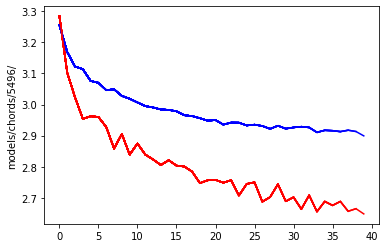

In [18]:
save_params()
train()

## 2.4 Comparación de modelos [2 pts]

En este último paso compararemos diferentes modelos. En la carpeta *models/chords* encontrarás los datos (en un formato similar al generado anteriormente) del entrenamiento de modelos similares con otros parámetros:

1.   carpeta: 2717-Shifted_True_...
2.   carpeta: 5102-Shifted_True_...



2.4.1 Compara los 3 modelos: grafica las funciones de loss para train y test de cada modelo.

*   Indica los parámetros de cada uno de los 3 modelos (el que habéis entrenado y los 2 que os hemos dado)
*   ¿Qué set de parámetros ha dado la mejor performance?
*   ¿Se aprecia overfitting en alguno de los modelos? Justifica tu respuesta

PARÁMETROS MODELO PROPIO
epochs: 10
train_set_size: 2000
test_set_size: 500
lstm_size: 128
embedding_dim: 10
learning_rate: 1e-05
shuffle_train_set: True
test_step: 500
bidirectional: False
num_chords: 50
chord_n: 3

PARÁMETROS MODELO 2717
epochs: 10
train_set_size: 2000
test_set_size: 500
lstm_size: 256
embedding_dim: 10
learning_rate: 1e-05
shuffle_train_set: True
test_step: 500
bidirectional: False
num_chords: 50
chord_n: 3

PARÁMETROS MODELO 5102
epochs: 20
train_set_size: 4000
test_set_size: 1000
lstm_size: 256
embedding_dim: 10
learning_rate: 1e-05
shuffle_train_set: True
test_step: 1000
bidirectional: False
num_chords: 50
chord_n: 3



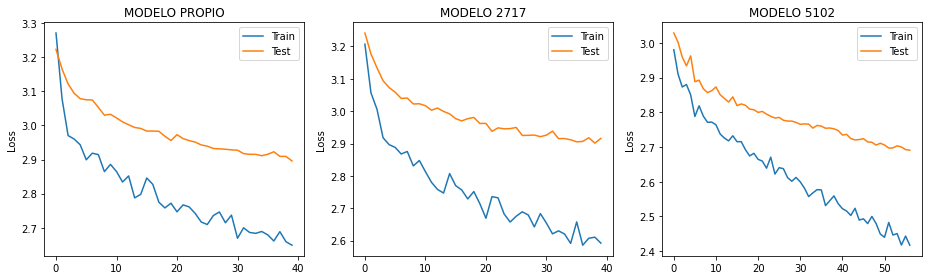

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# MODELO PROPIO

pathpropio = 'models/chords/1640' # Renombrado por problemas con la longitud del path original
p_a_propio = open(str(pathpropio + '/params.txt'))
ppropio = p_a_propio.read()
print('PARÁMETROS MODELO PROPIO\n' + ppropio)
p_a_propio.close()

train_a_propio = open(str(pathpropio + '/total_train_loss.pickle'), 'rb')
trainpropio = pickle.load(train_a_propio)

train_a_propio.close()

test_a_propio = open(str(pathpropio + '/total_test_loss.pickle'), 'rb')
testpropio = pickle.load(test_a_propio)

ax[0].plot(trainpropio[1])
ax[0].plot(testpropio[1])
ax[0].set_title('MODELO PROPIO')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])

test_a_propio.close()


# MODELO 2717

path2717 = 'models/chords/2717'
p_a_2717 = open(str(path2717 + '/params_0.txt'))
p2717 = p_a_2717.read()
print('PARÁMETROS MODELO 2717\n' + p2717)
p_a_2717.close()

train_a_2717 = open(str(path2717 + '/total_train_loss_array.pickle'), 'rb')
train2717 = pickle.load(train_a_2717)

train_a_2717.close()

test_a_2717 = open(str(path2717 + '/total_test_loss_array.pickle'), 'rb')
test2717 = pickle.load(test_a_2717)

ax[1].plot(train2717[1])
ax[1].plot(test2717[1])
ax[1].set_title('MODELO 2717')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Test'])

test_a_2717.close()


# MODELO 5102

path5102 = 'models/chords/5102' # Renombrado por problemas con la longitud del path original
p_a_5102 = open(str(path5102 + '/params_0.txt'))
p5102 = p_a_5102.read()
print('PARÁMETROS MODELO 5102\n' + p5102)
p_a_5102.close()

train_a_5102 = open(str(path5102 + '/total_train_loss_array.pickle'), 'rb')
train5102 = pickle.load(train_a_5102)

train_a_5102.close()

test_a_5102 = open(str(path5102 + '/total_test_loss_array.pickle'), 'rb')
test5102 = pickle.load(test_a_5102)

ax[2].plot(train5102[1])
ax[2].plot(test5102[1])
ax[2].set_title('MODELO 5102')
ax[2].set_ylabel('Loss')
ax[2].legend(['Train', 'Test'])

test_a_5102.close()


plt.tight_layout()

In [20]:
print('Loss modelo propio:\t', testpropio[1][-1],
      '\nLoss modelo 2717:\t', test2717[1][-1],
      '\nLoss modelo 5102:\t', test5102[1][-1])

Loss modelo propio:	 2.8958159993886947 
Loss modelo 2717:	 2.9159450919628145 
Loss modelo 5102:	 2.690847583383322


<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>El set de parámetros que mejor rendimiento ha dado es el del <b><i>modelo 5102</i></b>.<br><br>

<font color=#679532>No se puede apreciar un sobreentrenamiento evidente en las gráficas de <i>Loss</i> de los modelos. Sin embargo, tanto en el <i>modelo 2717</i> como en el <i>modelo 5102</i> se ven indicios de que la red podría empezar a sufrir sobreentrenamiento si se siguiese entrenando, ya que se empieza a apreciar que el <i>loss</i> de <i>test</i> comienza a disminuir en menor medida que el <i>Loss</i> de <i>train</i>. 

</div>

# 3 Análisis de la capa de embedding [2 pts]

En esta sección recrearemos la figura 8 del artículo con la red que hemos entrenado y la que mejor performance nos ha dado en la comparación. 

In [21]:
from keras.models import load_model
import keras
from keras import backend as K

## 3.1 Carga de modelos entrenados y generación de embeddings [1 pts]

3.1.1 Utiliza el *load_model* de **keras** para cargar:
*   el modelo que hemos entrenado: *my_model*
*   el modelo con mejor performance: *bp_model*


In [22]:
my_model = load_model(str(pathpropio + '/m_E10_2000.pickle'))
my_model._name = 'my_model'
bp_model = load_model(str(path5102 + '/model_Epoch14_4000.pickle'))
bp_model._name = 'bp_model'

3.1.2 Ahora crearemos, para cada modelo, un nuevo modelo para los embedding. Para hacer esto, deberás crear un nuevo modelo cuya entrada sea igual a la entrada de los modelos originales y la salida sea el layer "embedding". Esto lo puedes hacer usando la función *get_layer()* del modelo.


In [23]:
[i for i in my_model.get_layer('embedding').output.shape]

[1, 1, 10]

In [24]:
# my_model
my_model.get_layer('embedding')

my_embedding = Sequential()
my_embedding.add(my_model.get_layer('embedding'))
my_embedding._name = 'my_embedding'

my_embedding.summary()

# bp_model
bp_model.get_layer('embedding')

bp_embedding = Sequential()
bp_embedding.add(bp_model.get_layer('embedding'))
print('\n')
bp_embedding._name = 'bp_embedding'

bp_embedding.summary()

Model: "my_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1, 1, 10)                500       
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


Model: "bp_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1, 1, 10)                500       
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


3.1.3 El modelo de embedding recibe un acorde y devuelve un vector de 10 dimensiones con el embedding para cada acorde. Calcula estos vectores con cada uno de los modelos de embedding

In [25]:
my_v = my_embedding.predict([i for i in range(50)])
bp_v = bp_embedding.predict([i for i in range(50)])
print('Dimensión de los vectores de salida\nmy_embedding:\t', my_v.shape,
      '\nbp_embedding:\t', bp_v.shape)

Dimensión de los vectores de salida
my_embedding:	 (50, 1, 10) 
bp_embedding:	 (50, 1, 10)


3.1.4 Aplica un squeeze para eliminar los ejes de dimensión 1. El resultado de este squeeze debería ser (50,10)

In [26]:
my_v = np.squeeze(my_v)
bp_v = np.squeeze(bp_v)
print('Dimensión de los vectores de salida\nmy_embedding:\t', my_v.shape,
      '\nbp_embedding:\t', bp_v.shape)

Dimensión de los vectores de salida
my_embedding:	 (50, 10) 
bp_embedding:	 (50, 10)


## 3.2 Análisis PCA [1 pts]


Para acabar con nuestro análisis de los embeddings, vamos a realizar un proceso de PCA para reducir las dimensiones de los vectores resultantes y poder graficarlos en 2D.

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

3.2.1 Escalar los vectores y aplicar PCA para reducir a 2 las dimensiones

In [28]:
sc = StandardScaler()

my_sc = sc.fit_transform(my_v)
bp_sc = sc.fit_transform(bp_v)

pca = PCA(n_components=2)
my_pca = pca.fit_transform(my_sc)
bp_pca = pca.fit_transform(bp_sc)
print('Dimensión de los vectores PCA\nmy_embedding:\t', my_pca.shape,
      '\nbp_embedding:\t', bp_pca.shape)

Dimensión de los vectores PCA
my_embedding:	 (50, 2) 
bp_embedding:	 (50, 2)


3.2.2 Grafica para ambos embeddings los vectores en un scatterplot. Añadele anotaciones con las notas del acorde y comenta el resultado: ¿Observas el efecto word2vect en las gráficas?

Usa esta función para obtener un índice para los acordes y sus notas

In [29]:
def get_chord_dict():
    chord_to_index = pickle.load(open(dict_path + chord_dict_name, 'rb'))
    index_to_chord = pickle.load(open(dict_path + index_dict_name, 'rb'))
    return chord_to_index, index_to_chord

chord_to_index, idx_2_chord = get_chord_dict()

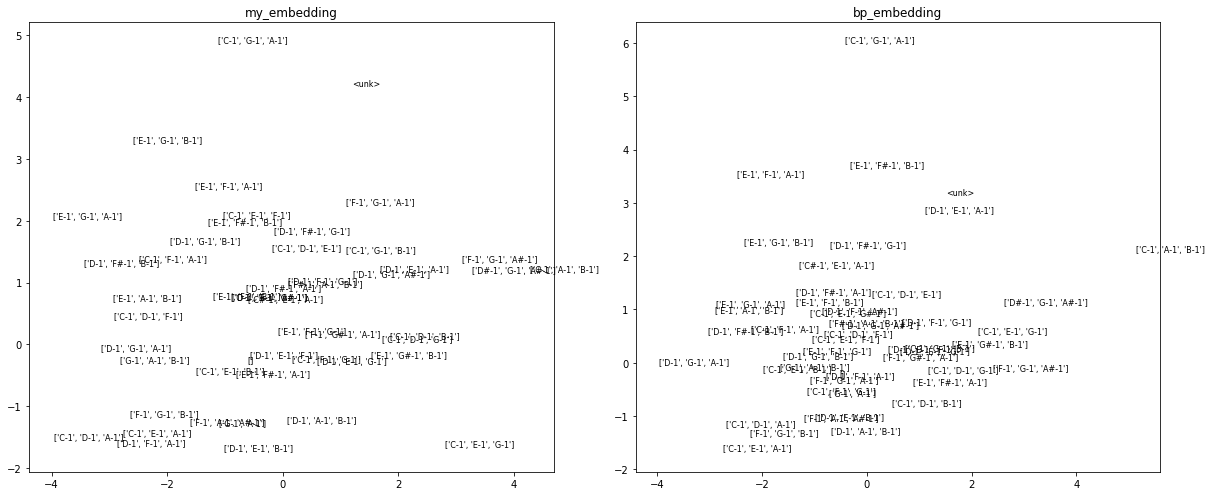

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

my_plot = my_pca.reshape(2,50)
bp_plot = bp_pca.reshape(2,50)

ax[0].scatter(my_plot[0], my_plot[1], color='white')
ax[0].set_title('my_embedding')
ax[1].scatter(bp_plot[0], bp_plot[1], color='white')
ax[1].set_title('bp_embedding')

ax[0].annotate('<unk>', (my_plot[0][0], my_plot[1][0]), fontsize = 8)
ax[1].annotate('<unk>', (bp_plot[0][0], bp_plot[1][0]), fontsize = 8)

for i in range(1, 50):
    ax[0].annotate([pm.note_number_to_name(idx_2_chord[i][j]) for j in range(len(idx_2_chord[i]))], (my_plot[0][i], my_plot[1][i]), fontsize = 8)
    ax[1].annotate([pm.note_number_to_name(idx_2_chord[i][j]) for j in range(len(idx_2_chord[i]))], (bp_plot[0][i], bp_plot[1][i]), fontsize = 8)

plt.tight_layout()

3.2.3 Crea una función para calcular todas las distancias entre los primero 20 acordes. Luego haz una lista con las 10 distancias mínimas para ambos modelos. ¿Están relacionados estos acordes con distancias mínimas?

In [31]:
def getIndexes(dfObj, value):
    '''https://thispointer.com/python-find-indexes-of-an-element-in-pandas-dataframe/'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    return listOfPos

def distancias(your_pca, n, m):
    d = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                d[i][j] = None
            else:
                d[i][j] = (np.sqrt((your_pca[j][0] - your_pca[i][0])**2 + (your_pca[j][1] - your_pca[i][1])**2))
    
    cn = [str([str(pm.note_number_to_name(idx_2_chord[i][j])) for j in range(len(idx_2_chord[i]))]) for i in range(1, 20)]
    cn.insert(0, "['<unk>']")
    df = pd.DataFrame(d, columns = cn)
    df.index = cn
    min_a = np.array([i for i in np.reshape(d,(n*n)) if i is not None])
    m_m = min_a[min_a.argsort()[:(m*2)]]
    m_m = np.delete(m_m, range(0,m*2, 2))
    ind = [(getIndexes(df, m_m[i])[0], m_m[i]) for i in range(m)]
    return df, ind

In [32]:
n = 20
m = 10
dist, minimos = distancias(my_pca, n, m)
print('Distancias entre los', m, 'acordes más cercanos entre sí:\n')
for i in range(len(minimos)):
    print(i+1,  'º:\t', minimos[i][0][0], '\n\t', minimos[i][0][1], '\n\t', minimos[i][1], '\n')

Distancias entre los 10 acordes más cercanos entre sí:

1 º:	 ['C-1', 'E-1', 'F-1'] 
	 [] 
	 0.32939698565459613 

2 º:	 ['C-1', 'G-1', 'B-1'] 
	 ['D-1', 'G-1', 'B-1'] 
	 0.5522792699400324 

3 º:	 [] 
	 ['F-1', 'G-1', 'A-1'] 
	 0.6821425625435317 

4 º:	 ['C-1', 'D-1', 'G-1'] 
	 ['D-1', 'G-1', 'B-1'] 
	 0.771438887935561 

5 º:	 ['D-1', 'F-1', 'G-1'] 
	 ['D-1', 'F-1', 'A-1'] 
	 0.9285554302036254 

6 º:	 ['C-1', 'E-1', 'A-1'] 
	 ['C-1', 'E-1', 'G-1'] 
	 0.9594547636867163 

7 º:	 ['C#-1', 'E-1', 'A-1'] 
	 ['F-1', 'G-1', 'B-1'] 
	 0.9817516027043821 

8 º:	 ['C-1', 'E-1', 'F-1'] 
	 ['F-1', 'G-1', 'A-1'] 
	 0.9909023763443243 

9 º:	 [] 
	 ['D-1', 'G-1', 'A-1'] 
	 0.9973312211991725 

10 º:	 ['C-1', 'E-1', 'F-1'] 
	 ['D-1', 'G-1', 'A-1'] 
	 1.0091959525051957 



<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>Los acordes con distancias mínimas sí están relacionados. Por ejemplo, los acordes <b>['C-1', 'G-1', 'B-1']</b> y <b>['D-1', 'G-1', 'B-1']</b> están separados por una distancia de <b><i>0.552</b></i>, y tan solo difieren en la primera nota (el primero <b>C-1</b> y el segundo <b>D-1</b>), que son, además consecutivas. Por lo tanto, el sonido de ambos acordes es muy parecido.

</div>

# 4. Rueda de 5tas (Bonus Track) [0.5 pts]

En este bonus track, y usando lo mismo que has usado para los apartados anteriores, podrás dibujar la rueda de quintas con datos entrenados sobre la misma base de datos, pero no hacer el shifteo de los acordes.

Usa los datos que encontrarás en la carpeta *models/chords/9671-Shifted_False...* para repetir el proceso del análisis de PCA

Una vez tienes los vectores, llama a las siguientes funciones para dibujar la rueda de quintas

In [33]:
def get_chord_dict_no_shifted():
    chord_to_index = pickle.load(open('data/chord_dict.pickle', 'rb'))
    index_to_chord = pickle.load(open('data/index_dict.pickle', 'rb'))
    return chord_to_index, index_to_chord

chord_to_index_, idx_2_chord_ = get_chord_dict_no_shifted()

In [34]:
ddd={tuple((0,4,7)):'C',
tuple((1,5,8)):'C#',
tuple((2,6,9)):'D',
tuple((3,7,10)):'D#',
tuple((4,8,11)):'E',
tuple((0,5,9)):'F',
tuple((1,6,10)):'F#',
tuple((2,7,11)):'G',
tuple((0,3,8)):'G#',
tuple((1,4,9)):'A',
tuple((2,5,10)):'A#',
tuple((3,6,11)):'B'}


def plot_5th_circle(X_chords_2d):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    
    plt.tick_params(labelsize=12)
    
    style = dict(size=12, color='black')
    
    for i in range(0,len(idx_2_chord_)):
        try:
            ax.text(-X_chords_2d[i,0]-0.32,X_chords_2d[i,1]+0.11, ddd[idx_2_chord_[i]],**style)
            ax.scatter(-X_chords_2d[i,0],X_chords_2d[i,1], c="blue", marker="*")
            
        except:
            pass
    plt.show()

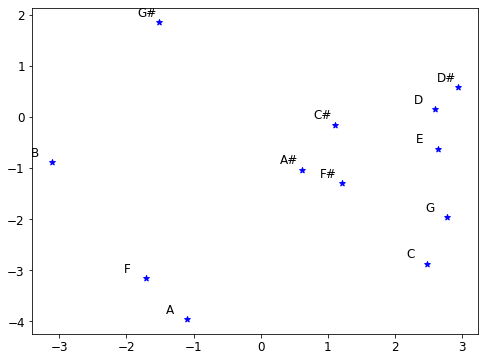

In [35]:
plot_5th_circle(my_pca) #pasa los vectores luego del análisis de PCA